In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
from pandas_datareader import data as pdata
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FactorAnalysis
# import BasicUtilities as bu
from scipy import interpolate
import scipy.stats as st
import scipy.signal
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import statsmodels.api as sm
import qfl.utilities.BasicUtilities as bu
%matplotlib inline

In [2]:
volatilityIndicator = 'Volatility252'
volatilityWindow = 252
macroIndicatorMaWindow = 6
macroIndicatorHalflife = 3
emMacroIndicatorHalflife = 1
startDateStr = '1/1/1956'
startDate = dt.datetime(1966, 1, 1)
exclude87 = False
excludeStartDate = dt.datetime(1987, 10, 19)
excludeEndDate = dt.datetime(1987, 10, 21)
levelGridMin = -5
levelGridMax = 2
changeGridMin = -3
changeGridMax = 3
timeWeightParameter = 50
simulationStartDate = dt.datetime(2015, 1, 1) 
troughs = [0.5, 3.0, 5.0]
lengths = [12.0, 15.0, 18.0]
simPeriods = 12
phase = 2.5

In [3]:
##############################################################################
# Macro model
##############################################################################

macroStartDate = dt.datetime(1980, 1, 1)

config_filename = 'qfl/macro/macro_model_cfg.csv'
config_table = pd.read_csv(config_filename)

dataFields = config_table['FRED_CODE'].tolist()
dataFieldNames = config_table['SERIES_NAME'].tolist()

useLog = config_table['USE_LOG'].tolist()
maLength = config_table['MA_LENGTH'].tolist()
divGdp = config_table['DIV_GDP'].tolist()

quarterlyDataFields = ['CRDQUSAPABIS', 'Total Credit Non-Financial']    

rawMacroData = pdata.get_data_fred(dataFields, macroStartDate)
macroData = rawMacroData.copy()

In [4]:
# Get GDP data and fill in divisors
gdp_data = pdata.get_data_fred('GDPC1', macroStartDate)
macroData['GDP'] = gdp_data
macroData['GDP'] = macroData['GDP'].fillna(method='ffill')
macroData['GDP'] = macroData['GDP'].fillna(method='bfill')

In [5]:
# filling in data
otherRetailSales = pdata.get_data_fred('RETAIL', macroStartDate)
levelsRatio = otherRetailSales['RETAIL'] \
    [otherRetailSales.index == dt.datetime(1992, 1, 1)] \
    / macroData['RSXFS'][macroData.index == dt.datetime(1992, 1, 1)][0]
otherRetailSales = otherRetailSales['RETAIL'] / levelsRatio[0]
macroData['DepreciatedRetail'] = otherRetailSales
macroData['RSXFS'][np.isnan(macroData['RSXFS'])] \
    = macroData['DepreciatedRetail'][np.isnan(macroData['RSXFS'])]
del macroData['DepreciatedRetail']

In [6]:
# claims data
# claims = pdata.get_data_fred('IC4WSA', macroStartDate)
# claims = claims.resample('M')
# claims.index = claims.index + pd.tseries.offsets.BDay(1)
# tmp = []
# for t in range(0, len(claims)):
#     tmp.append(dt.datetime(claims.index[t].year, claims.index[t].month, 1))
# claims.index = pd.DatetimeIndex(tmp)
# macroData['Claims'] = claims
# dataFields_ = list(dataFields)
# dataFields_.append('Claims')
# dataFieldNames_ = list(dataFieldNames)
# dataFieldNames_.append('Jobless Claims')

In [7]:
# manual override 
macroData['UMCSENT'][macroData.index == dt.datetime(2015, 8, 1)] = 91.9
macroData['UMCSENT'][macroData.index == dt.datetime(2015, 9, 1)] = 87.2
macroData['UMCSENT'][macroData.index == dt.datetime(2015, 10, 1)] = 90.0
macroData['UMCSENT'][macroData.index == dt.datetime(2015, 11, 1)] = 91.3
macroData['UMCSENT'][macroData.index == dt.datetime(2015, 12, 1)] = 92.6

tmp = macroData['DTBTM'][macroData.index == dt.datetime(2015, 10, 1)]
macroData['DTBTM'][macroData.index == dt.datetime(2015, 11, 1)] = tmp[0] 

macroData['DTBTM'][macroData.index == dt.datetime(2015, 12, 1)] \
    = macroData['DTBTM'][macroData.index == dt.datetime(2015, 11, 1)][0]
# macroData['TTLCONS'][macroData.index == dt.datetime(2015, 12, 01)] = 
# macroData['TTLCONS'][macroData.index == dt.datetime(2015, 11, 01)][0]

In [16]:
series_start_dates = pd.DataFrame(index=dataFields, columns=['date'])
for dataField in dataFields:
    series_start_dates.loc[dataField] = macroData[dataField] \
    [np.isfinite(macroData[dataField])].index.min()

In [8]:
# Get LEI

leiData = pdata.get_data_fred('USSLIND', startDate)

# leiData.index = leiData.index + pd.tseries.offsets.BDay(1)
# leiData.index = leiData.index + pd.tseries.offsets.BDay(-1)

# Recessions
recessionData = pdata.get_data_fred('USRECD', startDateStr)
recessionStartDates = []
recessionEndDates = []
for i in range(1, len(recessionData)):
    if (recessionData.values[i][0] == 0) & (recessionData.values[i-1][0] == 1):
        recessionEndDates.append(recessionData.index[i])    
    elif (recessionData.values[i][0] == 1) & (recessionData.values[i-1][0] == 0):
        recessionStartDates.append(recessionData.index[i])

In [9]:
##############################################################################
# Constructing the factor model dataset
##############################################################################

seriesStartDate = []
seriesEndDate = []
for i in range(0, len(dataFields)):
    if useLog[i] == 1:
        macroData[dataFields[i]] = np.log(macroData[dataFields[i]])
    if divGdp[i] == 1:
        macroData[dataFields[i]] = macroData[dataFields[i]] / macroData['GDP']
del macroData['GDP']

macroData1d = macroData.diff(1)

# manual override 
macroData1d['DTBTM'][macroData1d.index == dt.datetime(2010, 12, 1)] = -0.05

macroData1d_3m = macroData1d.rolling(window=3, center=False).mean()
macroData1d_6m = macroData1d.rolling(window=6, center=False).mean()
macroData1d_ma = pd.DataFrame()
for i in range(0, len(dataFieldNames)):
    macroData1d_ma[dataFields[i]] = macroData1d[dataFields[i]] \
        .rolling(window=maLength[i], center=False).mean()
    tmp = macroData1d_ma[dataFields[i]][~np.isnan(macroData1d_ma[dataFields[i]])]  
    if len(tmp.index) > 0:
        seriesStartDate.append(tmp.index[0])
        seriesEndDate.append(tmp.index[len(tmp.index)-1])
    else:
        seriesStartDate.append(startDate)
        seriesEndDate.append(dt.datetime.today())
    
commonStartDate = max(seriesStartDate)
commonEndDate = min(seriesEndDate)

'WHLSLRSMSA ... Merchant Wholesalers Sales ... 12'

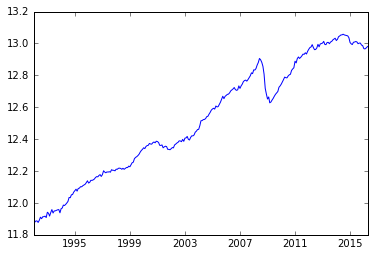

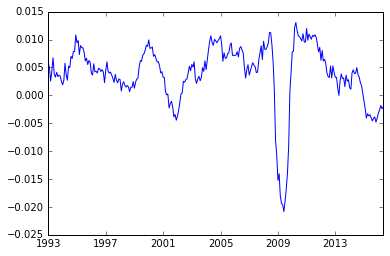

In [10]:
i=25
fieldname = 'LNS12032197'
fieldname = dataFields[i]
plt.figure(1)
plt.plot(macroData[fieldname])
plt.figure(2)
plt.plot(macroData1d_ma[fieldname])
dataFields[i] + " ... " + dataFieldNames[i] + " ... " + str(maLength[i])

In [11]:
##############################################################################
# Autoregression coefficients and trend coefficients
##############################################################################

reg_outputs = dict()
ar1_coefs = np.zeros((len(dataFields), 5))
predictedData = pd.DataFrame()
cleanData = macroData1d_ma.copy()
cleanData = cleanData[cleanData.index > commonStartDate]
daysSinceStart = (macroData.index - macroData.index[0]).days
daysSinceStartDf = pd.DataFrame(daysSinceStart)
daysSinceStartDf.index = macroData.index
for i in range(0, len(dataFields)):
    
    # Trend coefficients

    tmp = pd.ols(y=macroData[dataFields[i]],
                 x=daysSinceStartDf[0])
    
    tmp = pd.ols(y=macroData[dataFields[i]],
                 x=macroData[dataFields[i]].shift(1))
    ar1_coefs[i,0] = (tmp.beta['x'])
    
    tmp = pd.ols(y=macroData1d[dataFields[i]],
                 x=macroData1d[dataFields[i]].shift(1))
    ar1_coefs[i,1] = (tmp.beta['x'])
    
    tmp = pd.ols(y=macroData1d_3m[dataFields[i]],
                 x=macroData1d_3m[dataFields[i]].shift(1))
    ar1_coefs[i,2] = (tmp.beta['x'])
    
    tmp = pd.ols(y=macroData1d_6m[dataFields[i]],
                 x=macroData1d_6m[dataFields[i]].shift(1))
    ar1_coefs[i,3] = (tmp.beta['x'])
    
    tmp = pd.ols(y=macroData1d_ma[dataFields[i]],
                 x=macroData1d_ma[dataFields[i]].shift(1))
    ar1_coefs[i,4] = (tmp.beta['x'])
    
ar1_coefs = pd.DataFrame(data=ar1_coefs,
                         index=dataFields,
                         columns=['levels', 'd1', 'd3', 'd6', 'dma'])
ar1_coefs['ma_length'] = maLength

/Users/benneifert/anaconda/envs/qfl_dev/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2885: FutureWarning: The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://statsmodels.sourceforge.net/stable/regression.html
  exec(code_obj, self.user_global_ns, self.user_ns)


In [337]:
ar1_coefs

In [12]:
##############################################################################
# Factor model
##############################################################################

num_factors = 4
    
pcaInd = (macroData1d_ma.index > commonStartDate) \
         & (macroData1d_ma.index <= commonEndDate)
inSampleMeans = np.mean(macroData1d_ma[pcaInd])
inSampleStdev= np.std(macroData1d_ma[pcaInd])
inSampleZscores = (macroData1d_ma[pcaInd] - inSampleMeans) / inSampleStdev

princomp = PCA(n_components = num_factors)

pcaData = np.array(inSampleZscores)
pcaDates = inSampleZscores.index
s1 = princomp.fit(pcaData).transform(pcaData)
eye = np.identity(pcaData.shape[1])
w1 = princomp.fit(pcaData).transform(eye)
components = pd.DataFrame(data=princomp.components_.transpose(),
                          index=dataFieldNames)

fa = FactorAnalysis(n_components = num_factors)
f1 = fa.fit(pcaData)
f2 = f1.transform(pcaData)
w2 = f1.transform(eye)

# rng = np.random.RandomState(42)
# ica = FastICA(random_state=rng)
# s2 = ica.fit(pcaData).transform(pcaData)  

# Factors dataset
pcaFactors = pd.DataFrame(s1)
pcaFactors.index = pcaDates

# Reverse factor direction if off

# F1 is growth
if components.loc['Unemployment Rate', 0] > 0:
    components[0] = -components[0]
    pcaFactors[0] = -pcaFactors[0]
    
# F2 is inflation/credit
if components.loc['Total Consumer Credit', 1] < 0:
    components[1] = -components[1]
    pcaFactors[1] = -pcaFactors[1]
    
# F3 is real estate
if components.loc['Total Construction Spending', 2] < 0:
    components[2] = -components[2]
    pcaFactors[2] = -pcaFactors[2]
    
# F4 is the labor market
if components.loc['Unemployment Rate', 3] > 0:
    components[3] = -components[3]
    pcaFactors[3] = -pcaFactors[3]

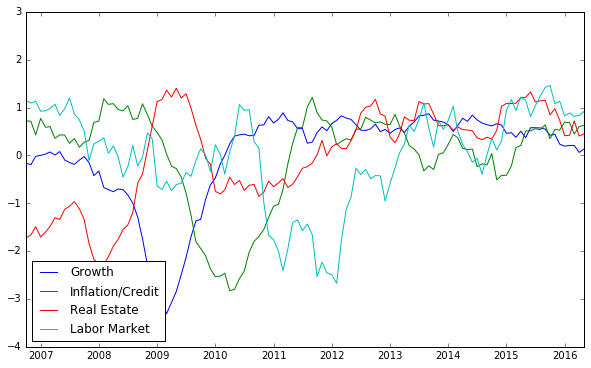

In [14]:
fig = plt.figure(figsize=[10, 6])
plot_var = pcaFactors.rolling(window=1, center=False).sum()
plt.plot(plot_var / plot_var.std())
plt.legend(['Growth', 'Inflation/Credit', 'Real Estate', 'Labor Market'], loc=3)
plt.ylim([-4, 3])
plt.savefig('factor_model.png')

In [24]:
# Get S&P 500 data
sp500 = pdata.DataReader('^GSPC',
                         data_source='yahoo',
                         start=startDateStr,
                         end=dt.datetime.today())
sp500 = sp500['Adj Close']
sp500_returns = np.log(sp500) - np.log(sp500).shift(1)

if exclude87:
    sp500_returns[(sp500_returns.index >= excludeStartDate)
                  & (sp500_returns.index <= excludeEndDate)] = 0

vol_windows = [21, 63, 126, 252]
variableNames =[]
sp500_volatility = pd.DataFrame()
sp500_volatility_lead = pd.DataFrame()
for i in range(0, len(vol_windows)):
    variableNames.append('Volatility' + str(vol_windows[i]))
    sp500_volatility[variableNames[i]] =  np.sqrt(252.0 
        * sp500_returns.rolling(window=vol_windows[i],
                                center=False).var())
    sp500_volatility_lead[variableNames[i]] = sp500_volatility[
        variableNames[i]].shift(-vol_windows[i])

indVars = pd.DataFrame()
indVars['Volatility21'] = sp500_volatility['Volatility21']
indVars['Volatility63'] = sp500_volatility['Volatility63']
indVars['Volatility252'] = sp500_volatility['Volatility252']

capFactor = 2.5
sp500_returns_capped = sp500_returns.copy()
ind = (np.abs(sp500_returns) > capFactor * indVars['Volatility252'] / np.sqrt(252))
sp500_returns_capped[ind] = np.sign(sp500_returns[ind]) \
    * capFactor * indVars['Volatility252'] / np.sqrt(252)

variableNames = []
sp500_volatility_c = pd.DataFrame()
sp500_volatility_lead_c = pd.DataFrame()
for i in range(0, len(vol_windows)):
    variableNames.append('Volatility' + str(vol_windows[i]))
    sp500_volatility_c[variableNames[i]] = np.sqrt(252.0 
        * sp500_returns_capped.rolling(window=vol_windows[i],
                                       center=False).var())
    sp500_volatility_lead_c[variableNames[i]] =\
        sp500_volatility[variableNames[i]].shift(-vol_windows[i])

In [123]:
##############################################################################
# Data aggregation
##############################################################################

# Assign zeros to recession dates since last data point
tmpDt = recessionData.index[len(recessionData)-1]
df = pd.DataFrame(sp500.index[sp500.index > tmpDt])
df.index = sp500.index[sp500.index > tmpDt]
df['USRECD'] = 0
del df['Date']
recessionData = pd.DataFrame.append(recessionData, df)

# choice of macro data variable
macroIndicator = leiData.copy()

indVarsDf = pd.DataFrame()
indVarsDf[0] = sp500_volatility_c[volatilityIndicator].copy()
# indVarsDf[1] = sp500_volatility_c['Volatility63']
# indVarsDf[2] = sp500_volatility_c['Volatility252']

volAcReg = pd.ols(y=sp500_volatility_lead_c[volatilityIndicator],
                  x=indVarsDf)
residualVolatility = volAcReg.resid

volAcRegOverlap = pd.ols(y=sp500_volatility_lead_c[volatilityIndicator],
                         x=sp500_volatility_lead_c[volatilityIndicator].shift(21))
residualVolatilityOverlap = volAcRegOverlap.resid

In [124]:
# Nonparametric data structures

npd = pd.DataFrame()
npd['Volatility'] = sp500_volatility_lead_c[volatilityIndicator].copy()
npd['ResidualVolatility'] = residualVolatility
npd['ResidualVolatilityOverlap'] = residualVolatilityOverlap
npd['TrailingVolatility'] = sp500_volatility_c[volatilityIndicator].copy()
# Make sure everything lines up on business days
npd.index = npd.index + pd.tseries.offsets.BDay(0)
# pcaFactors.index = pcaFactors.index + pd.tseries.offsets.BDay(0)
npd['F1'] = macroIndicator

# Reduce to monthly dataset
npd = npd[~np.isnan(npd['F1'])]

# Lags and changes
macroIndicatorMa = macroIndicator.ewm(halflife=macroIndicatorHalflife,
                                      ignore_na=True,
                                      min_periods=0,
                                      adjust=True).mean()
npd['DF1'] = macroIndicatorMa - macroIndicatorMa.shift(macroIndicatorMaWindow)
npd['LF1'] = macroIndicatorMa.shift(macroIndicatorMaWindow)
npd['F1M'] = macroIndicatorMa

# Zscores of lags and changes
npd['ZDF1'] = (npd['DF1'] - npd['DF1'].mean()) / npd['DF1'].std()
npd['ZLF1'] = (npd['LF1'] - npd['LF1'].mean()) / npd['LF1'].std()
npd['ZF1M'] = (npd['F1M'] - npd['F1M'].mean()) / npd['F1M'].std()

macroIndicatorMa12 = macroIndicator.rolling(window=12, center=False).sum()
npd['F1M12'] = macroIndicatorMa12
npd['F1M12Z'] = (macroIndicatorMa12 - macroIndicatorMa12.mean()) / macroIndicatorMa12.std()

In [125]:
##############################################################################
# Nonparametric analysis
##############################################################################

# time weights for recency weighting
npd['TimeWeights'] = np.exp(((npd.index - npd.index[len(npd.index)-1]).days
                             / timeWeightParameter / 365.0))

# Grid
x = np.linspace(levelGridMin, levelGridMax, 20)
y = np.linspace(changeGridMin, changeGridMax, 20)
xv, yv = np.meshgrid(x, y)
outGrid = [xv, yv]

# International grid
xvi, yvi = np.meshgrid(x, x)
outGrid_i = [xvi, yvi]

# nonparametric plot data (nppd)
nppd = pd.DataFrame()
# nppd['ZLF1'] = npd['ZLF1']
nppd['ZF1M'] = npd['ZF1M']
nppd['ZDF1'] = npd['ZDF1']
indVar = np.array(nppd)
depVar_res = np.array(npd['ResidualVolatility'])
depVar_reso = np.array(npd['ResidualVolatilityOverlap'])
depVar = np.array(npd['Volatility'])

# Run nonparametric analysis
bandwidth = 1
predGrid = bu.npreg(depVar, indVar, outGrid, bandwidth, npd['TimeWeights'].values)   
bandwidth = 1.5
predGrid_res = bu.npreg(depVar_res, indVar, outGrid, bandwidth, npd['TimeWeights'].values)
bandwidth = 1.5
predGrid_reso = bu.npreg(depVar_reso, indVar, outGrid, bandwidth, npd['TimeWeights'].values)
# bandwidth = 1
# predGrid_int = bu.npreg(depVar, indVar_int, outGrid_i, bandwidth, npd['TimeWeights'].values)

# Get interpolation
f = interpolate.interp2d(x, y, predGrid, kind='linear')
f_res = interpolate.interp2d(x, y, predGrid_res, kind='linear')
f_reso = interpolate.interp2d(x, y, predGrid_reso, kind='linear')
# f_int = interpolate.interp2d(x, x, predGrid_int, kind='linear')

In [126]:
##############################################################################
# Recession simulations
##############################################################################

# Generate simulations
macroIndicatorSimData = macroIndicatorMa[macroIndicatorMa.index > simulationStartDate]  
macroIndicatorSimPath = np.zeros([simPeriods, len(troughs)])
for i in range(0, simPeriods):
    for j in range(0, len(troughs)):
        if i == 0:
            macroIndicatorSimPath[i,j] = macroIndicatorSimData.values[len(macroIndicatorSimData)-1]
        else:
            if i <= lengths[j]:
                a =  np.sin(phase + (i+1) * 2.0 * np.pi / lengths[j]) * troughs[j] / 2.0 - troughs[j]/2.0
                b =  np.sin(phase+ (i) * 2.0 * np.pi / lengths[j]) * troughs[j] / 2.0 - troughs[j]/2.0
                macroIndicatorSimPath[i,j] = macroIndicatorSimPath[i-1,j] + a - b
            elif i <= 2 * lengths[j]:
                macroIndicatorSimPath[i,j] = macroIndicatorSimPath[i-1,j]
            else:
                macroIndicatorSimPath[i,j] = macroIndicatorSimPath[i-1,j]

In [127]:
simDates = []
simDates.append(simulationStartDate)
for i in range(1, len(macroIndicatorSimData) + simPeriods):
    simDates.append(simDates[i-1] + relativedelta(months=1))
simDates = pd.DataFrame(index=simDates).index + pd.tseries.offsets.BDay(0)

tmp = np.zeros([len(macroIndicatorSimData), 3])
tmp[:,0] = macroIndicatorSimData.values[:,0]
tmp[:,1] = macroIndicatorSimData.values[:,0]
tmp[:,2] = macroIndicatorSimData.values[:,0]
finalSimPath = np.vstack((tmp, macroIndicatorSimPath))
finalSimPath = pd.DataFrame(finalSimPath)
finalSimPath.index = simDates
df1_path = finalSimPath - finalSimPath.shift(macroIndicatorMaWindow)
f1_path = finalSimPath

# vol_path =  np.zeros([len(finalSimPath), 3])
# for i in range(0, len(finalSimPath)):
#     for j in range(0, len(troughs)):
#         if simDates[i] < dt.datetime.today():
#         # if i < len(macroIndicatorSimData):
#             if simDates[i] in sp500_volatility.index:
#             #vol_path[i,j] = npd['TrailingVolatility'][macroIndicatorSimData.index[i]]
#                 useDate = simDates[i]
#                 vol_path[i,j] = sp500_volatility[volatilityIndicator][useDate] 
#             elif workdays.workday(simDates[i], 1) in sp500_volatility.index:
#                 useDate = workdays.workday(simDates[i], 1)
#                 vol_path[i,j] = sp500_volatility[volatilityIndicator][useDate] 
#             elif workdays.workday(simDates[i], -1) in sp500_volatility.index:
#                 useDate = workdays.workday(simDates[i], -1)
#                 vol_path[i,j] = sp500_volatility[volatilityIndicator][useDate] 
#             elif workdays.workday(simDates[i], 2) in sp500_volatility.index:
#                 useDate = workdays.workday(simDates[i], 2)
#                 vol_path[i,j] = sp500_volatility[volatilityIndicator][useDate] 
#             elif workdays.workday(simDates[i], -2) in sp500_volatility.index:
#                 useDate = workdays.workday(simDates[i], -2)
#                 vol_path[i,j] = sp500_volatility[volatilityIndicator][useDate] 
#         else:
#             vol_path[i,j] = volAcRegOverlap.beta.intercept + (volAcRegOverlap.beta[0] - 0.01) * vol_path[i-1,j] 
#             + f_res(f1_path[j][i], df1_path[j][i]) / (volatilityWindow / 21 / 6)

In [128]:
##############################################################################
# Recession probabiliy  
############################################################################## 


# Logit for probability of recession

r2 = []
ll = []
recessionProbs = pd.DataFrame()
recessionProbs['Date'] = macroIndicator.index
recessionProbs.index = macroIndicator.index

recessionInWindow = pd.DataFrame(recessionProbs['Date'])
recessionPredictionWindow = 252   
tmp = recessionData.rolling(window=recessionPredictionWindow, center=False).sum()
tmp2 = tmp.shift(-recessionPredictionWindow)
recessionInWindow['RIW'] = np.minimum(1, tmp2)
windows = [1, 3, 6, 9, 12, 18, 24]
halflifes = [0.5, 1, 2, 3, 6, 9, 12]
logits = []
regs = []

for i in range(0, len(windows)):
    
    logitIv = pd.DataFrame(recessionData.index)
    logitIv.index = recessionData.index
    logitIv['Recession'] = recessionData
    logitIv['RecessionInWindow'] = recessionInWindow['RIW']
    windowMa = macroIndicator.ewm(halflife=halflifes[i], ignore_na=False, min_periods=0, adjust=True).mean()
    logitIv['F1M'] = windowMa.copy()
    logitIv['LF1'] = windowMa.shift(windows[i])
    logitIv['DF1'] = windowMa.diff(halflifes[i] * 2)
    logitIv['INT'] = logitIv['F1M'] * logitIv['DF1']
    logitIv = logitIv[(~np.isnan(logitIv['DF1'])) & (~np.isnan(logitIv['F1M']))]
    logitIv['RecessionInWindow'][np.isnan(logitIv['RecessionInWindow'])] = 0
    tmp = sm.Logit(logitIv['RecessionInWindow'], logitIv[['F1M', 'DF1', 'INT']])
    result = tmp.fit()
    predictions = result.fittedvalues[~np.isnan(result.fittedvalues)]
    logits.append(result)
    
    ll.append(result.llr)
    recessionProbs[str(i)] = np.exp(predictions) / (1 + np.exp(predictions))
    
    # not really logit, but convenient
    logitIv['Volatility'] = npd['Volatility']
    logitIv['Volatility_Lag'] = logitIv['Volatility'].shift(volatilityWindow / 21)
    logitIv = logitIv[(~np.isnan(logitIv['Volatility'])) & (~np.isnan(logitIv['Volatility_Lag'])) ]
    tmp = sm.OLS(logitIv['Volatility'], logitIv['Volatility_Lag'] )
    result = tmp.fit()
    logitIv['Volatility_Res'] = result.resid
    logitIv = logitIv[~np.isnan(logitIv['Volatility_Res'])]
    # logitIv = logitIv[~np.isnan(logitIv['Volatility'])]
    tmp = sm.OLS(logitIv['Volatility_Res'], logitIv[['LF1', 'DF1', 'INT']])
    # tmp = sm.OLS(logitIv['Volatility'], logitIv[['LF1', 'DF1', 'INT']])
    result = tmp.fit()
    r2.append(result.rsquared)
    regs.append(result)

In [130]:
recessionProbs['Weighted'] = 0
for i in range(0, len(windows)):    
    recessionProbs['Weighted'] = recessionProbs['Weighted'] + recessionProbs[str(i)]  * ll[i] / np.sum(ll)
# del recessionProbs['Date']

In [59]:
##############################################################################
# Plotting
##############################################################################

currentDate = npd.index[len(npd.index)-1]
currentLevel = npd['ZF1M'][currentDate]
currentChange = npd['ZDF1'][currentDate]

# Transparent colormap
theCM = cm.get_cmap()
theCM._init()
alphas = np.abs(np.linspace(-1.0, 1.0, theCM.N))
theCM._lut[:-3,-1] = alphas

indVar = np.array(nppd)
depVar = np.array(npd['Volatility'])

# Figure 1: nonparametric 
fig = plt.figure(figsize=(16,8))
ax = fig.gca(projection='3d')
# scat = ax.scatter(indVar[:,0], indVar[:,1], depVar * 100.0, c = 'r')
scat = ax.scatter(currentLevel,
                  currentChange,
                  f(currentLevel, currentChange) * 100 + 2,
                  c = 'k',
                  s = 200,
                  zorder=10)
surf = ax.plot_surface(outGrid[0], outGrid[1], predGrid * 100.0, 
                       rstride=1, cstride=1, cmap=theCM,
                       linewidth=0, antialiased=False, zorder = 0)
ax.set_xlabel('F1')
ax.set_ylabel('Change in F1')
ax.set_zlabel('S&P realized volatility, next 1y')
ax.set_title('Subsequent 1y S&P realized volatility, versus Z-scores of level and change of US macro index')
ax.set_zlim([10, 35])
fmt = '%.0f%%' 
zticks = mtick.FormatStrFormatter(fmt)
ax.zaxis.set_major_formatter(zticks)
fig.colorbar(surf, shrink=0.5, aspect=5)
# plt.axis([-6, 3, -6, 3, 10, 30])
ax.view_init(30, 30)

In [132]:
# Figure 3: sustained market volatility is typically associated
# with economic downturns
fig = plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
plt.title('The US Economic Cycle and S&P-500 Realized Volatility')
plt.axis('normal')
ax1.plot(sp500_volatility['Volatility252'] * 100, 'b',linewidth=1.5)
# ax2.plot(-pd.rolling_sum(leiData, window=macroIndicatorMaWindow), 'g',linewidth=1.5)
ax2.plot(-npd['ZF1M'], 'g', linewidth = 1.5)
# ax2.plot(-npd['F1M12Z'], 'g', linewidth = 1.5)
ax1.set_ylabel("1y realized volatility, S&P 500",fontsize=12,color='blue')
ax2.set_ylabel("US macro index Z-score, inverted",fontsize=12,color='green')
ax1.set_ylim([0.0, 50])
# ax2.set_ylim([-3, 5])
ax1.grid(True)
for i in range(0, len(recessionStartDates)):
    a = recessionStartDates[i]
    b = recessionEndDates[i]
    plt.axvspan(a, b, color='grey', alpha=0.5, lw=0)
plt.show()

In [64]:
# Figure 3b: where are we at now?
plotStartDate = dt.datetime(1998, 1, 1)
fig = plt.figure(figsize=(14,8))
ax = plt.gca()
plt.title('Most recent two cycles')
plt.axis('normal')
ax.plot(npd['ZF1M'][npd.index > plotStartDate], 'g',linewidth=1.5)
ax.plot(npd['ZDF1'][npd.index > plotStartDate], 'k',linewidth=1.5)
ax.set_ylabel("Z-scores",fontsize=12,color='green')
ax.grid(True)
for i in range(0, len(recessionStartDates)):
    if recessionStartDates[i] > plotStartDate:
        a = recessionStartDates[i]
        b = recessionEndDates[i]
        plt.axvspan(a, b, color='grey', alpha=0.5, lw=0)
ax.set_ylim([-5, 5])
plt.legend(['Level Z', 'Change Z'])
plt.show()

In [66]:
# Figure 9:  
fig = plt.figure(figsize=(14,8))
ax = fig.gca()
plt.plot(recessionProbs['Weighted'])
ax.set_ylabel("Predicted probability of recession in next 12 months",fontsize=12,color='green')  
ax.grid(True)
for i in range(0, len(recessionStartDates)):
    a = recessionStartDates[i]
    b = recessionEndDates[i]
    plt.axvspan(a, b, color='grey', alpha=0.5, lw=0)
plt.show()